### Clustering and Fitting

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial as Poly
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde
import os # Set the environment variable 
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
#Reading the csv file
data_new = pd.read_csv("world.csv", index_col="Year", parse_dates=['Year'])
data_new.head()

,Population,Yearly Growth %,Number,Density (Pop/km2)
Year,,,,
1951-01-01,"2,543,130,380",1.75%,"43,808,223",17
1952-01-01,"2,590,270,899",1.85%,"47,140,519",17
1953-01-01,"2,640,278,797",1.93%,"50,007,898",18
1954-01-01,"2,691,979,339",1.96%,"51,700,542",18
1955-01-01,"2,746,072,141",2.01%,"54,092,802",18


In [5]:
#handling the dataset

data_new["Population"] = data_new["Population"].astype(str).str.replace(',','')
data_new["Yearly Growth %"] = data_new["Yearly Growth %"].astype(str).str.replace('%','')
data_new["Number"] = data_new["Number"].astype(str).str.replace(',','')
data_new

,Population,Yearly Growth %,Number,Density (Pop/km2)
Year,,,,
1951-01-01,2543130380,1.75,43808223,17
1952-01-01,2590270899,1.85,47140519,17
1953-01-01,2640278797,1.93,50007898,18
1954-01-01,2691979339,1.96,51700542,18
1955-01-01,2746072141,2.01,54092802,18
...,...,...,...,...
2019-01-01,7764951032,1.06,81161204,52
2020-01-01,7840952880,0.98,76001848,53
2021-01-01,7909295151,0.87,68342271,53


In [6]:
#changing the values in numeric

for col in data_new.columns:
    data_new[col] = pd.to_numeric(data_new[col])
data_new

,Population,Yearly Growth %,Number,Density (Pop/km2)
Year,,,,
1951-01-01,2543130380,1.75,43808223,17
1952-01-01,2590270899,1.85,47140519,17
1953-01-01,2640278797,1.93,50007898,18
1954-01-01,2691979339,1.96,51700542,18
1955-01-01,2746072141,2.01,54092802,18
...,...,...,...,...
2019-01-01,7764951032,1.06,81161204,52
2020-01-01,7840952880,0.98,76001848,53
2021-01-01,7909295151,0.87,68342271,53


In [7]:
#overview of dataset
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 1951-01-01 to 2023-01-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Population         73 non-null     int64  
 1   Yearly Growth %    73 non-null     float64
 2   Number             73 non-null     int64  
 3   Density (Pop/km2)  73 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 2.9 KB


In [8]:
#looking for null values

print(data_new.isnull().sum())

Population           0
Yearly Growth %      0
Number               0
Density (Pop/km2)    0
dtype: int64


### Categorical Graph
Plot the histogram with kernel density to show the distribution of Yearly growth

In [9]:
growth= data_new["Yearly Growth %"]

In [10]:
def plot_hist(growth):
    
    """
    Create a Histogram of growth with Kernal Density
    """
    plt.figure(figsize=(7,5), dpi=144)
    plt.axes(facecolor='lightgrey')
    plt.hist(growth, bins=15,density= True,color="black", edgecolor="white")
    kde = gaussian_kde(growth)
    x = np.linspace(min(growth), max(growth),1000)
    plt.plot(x, kde(x), color='red', lw=2, label="kernel Density")
    plt.xticks()
    plt.yticks()
    plt.xlabel("Yearly Growth(%)")
    plt.ylabel("Density / Frequency")
    plt.legend(frameon=True, shadow=True)
    plt.title("Distribution of Yearly Growth")
    plt.grid(color="white", alpha=0.3)
    plt.savefig("histogram",dpi=200)
    return

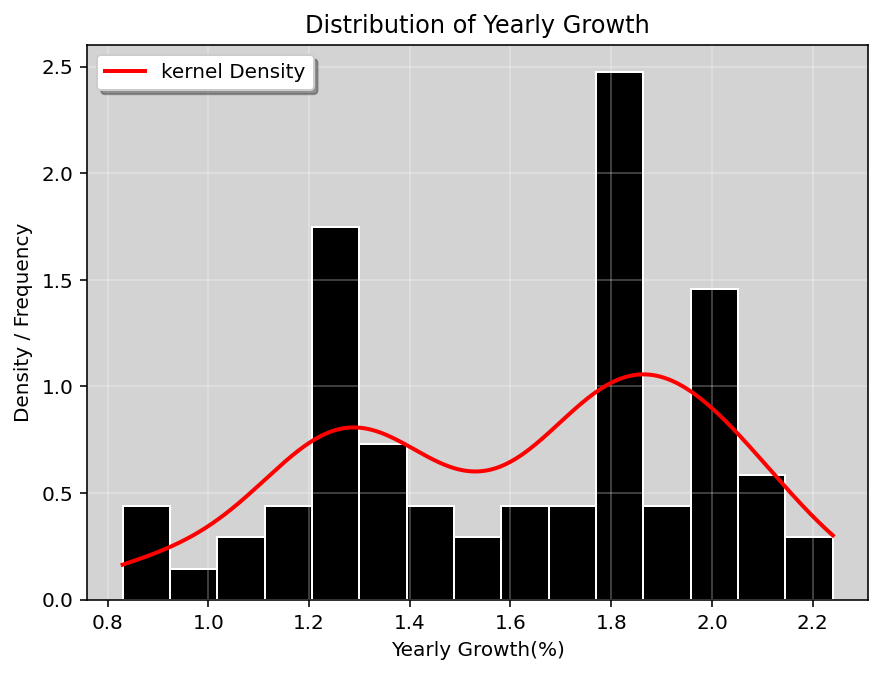

In [11]:
plot_hist(growth)

In [12]:
# Calculate skewness and kurtosis

skewness = skew(growth) 
kurtosis = kurtosis(growth, fisher = True)  

df = pd.DataFrame({"skewness":[skewness], "kurtosis":[kurtosis]}, index=["Yearly Growth %"])
df

,skewness,kurtosis
Yearly Growth %,-0.306786,-1.019669


### Relational Graph
Plot line diagram to show the relation between Population Density and year

In [13]:
def plot_pop_density(data):
    """
    plot the population density with a logarithmic y scale
    """
    fig, ax = plt.subplots(dpi=144)
    data.plot(y=['Density (Pop/km2)'], ax=ax, logy=True, ylabel="Density(pop/km2)" )
    plt.grid(which="major", linestyle=":", color="black",alpha=0.4)
    plt.ylim(15,60)
    plt.title("Population Density over the Years",fontsize=12,fontstyle="italic", fontweight="bold")
    plt.savefig("density", dpi=200)
    return


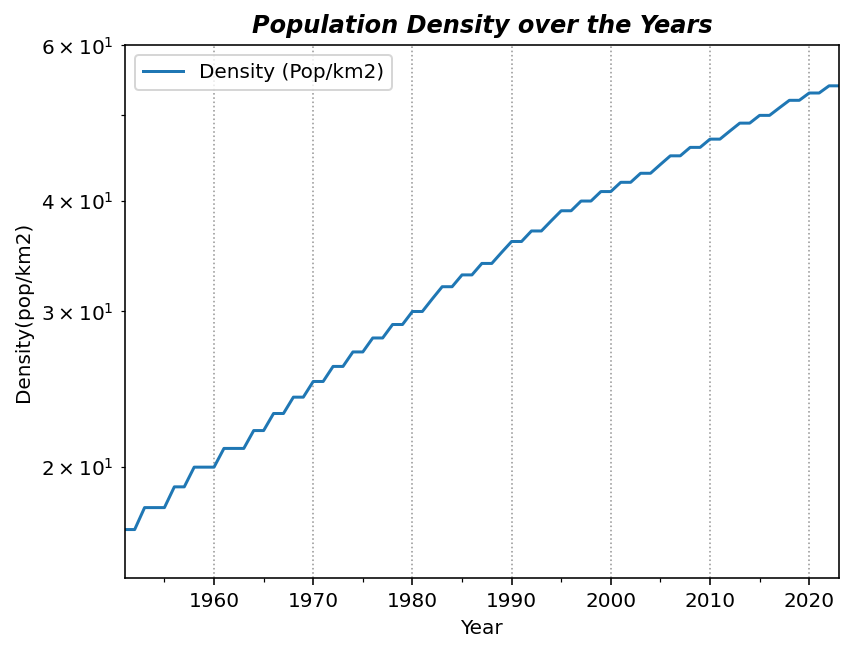

In [14]:
plot_pop_density(data_new)

### Fitting 
Determine the best line to fit the Popultaion Density

In [15]:
def exponential(t, n0, g):
    """
    Calculates exponential function with scale factor n0 and growth rate g.
    """
    f = n0 * np.exp(g*t)
    
    return f

In [16]:
numeric_index = (data_new.index.year - 1951).values

# give some initial guesses of N0 and growth
p, cov = curve_fit(exponential, numeric_index, data_new['Density (Pop/km2)'],
                   p0=(17, 0.053))

sigma = np.sqrt(np.diag(cov))

print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")

N0 = 18.7647 +/- 0.20465
g = 0.02 +/- 0.00


In [17]:
# adding a new column of calculated Exponential fit

data_new['Exponential Fit'] = exponential(numeric_index, *p)

In [18]:
def plot_expo_density(data):
    """
    plot the exponential fit of population density
    """
    fig, ax = plt.subplots(dpi=144)
    data.plot(y=['Density (Pop/km2)', 'Exponential Fit'], logy=True, ax=ax, ylabel='Density (Pop/km2')
    plt.grid(which="major", linestyle=":", color="black",alpha=0.4)
    plt.title("Population Density with Exponential Fit",fontsize=12,fontstyle="italic", fontweight="bold")
    plt.savefig("expo", dpi=200)
    return


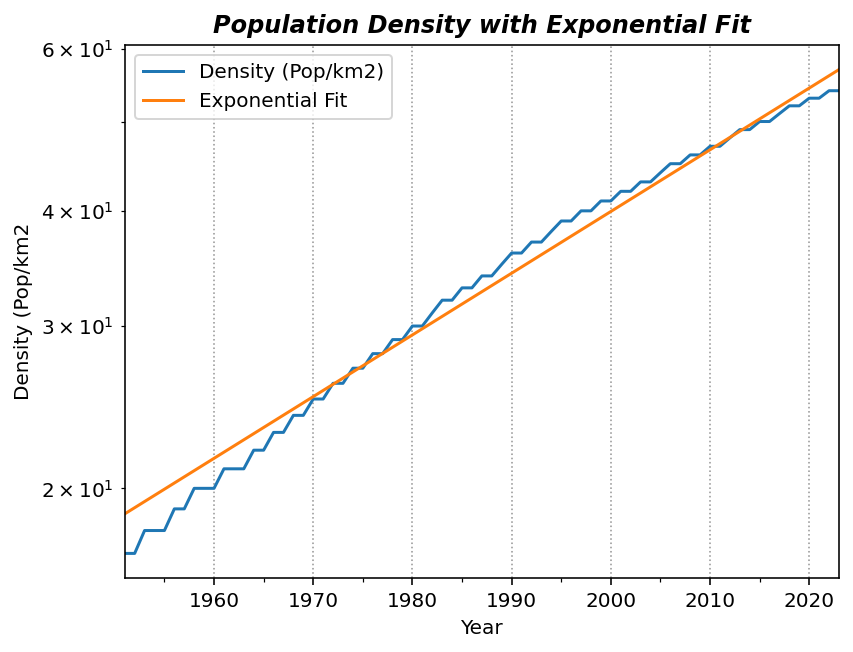

In [19]:
plot_expo_density(data_new)

In [20]:
def logistic(t, n0, g, t0):
    """
    Calculates the logistic function with scale factor n0 and growth rate g
    """
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f

In [21]:
p, cov = curve_fit(logistic, numeric_index, data_new['Density (Pop/km2)'],
                  p0=(60, 0.05, 30))

sigma = np.sqrt(np.diag(cov))

print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")
print(f"t0 = {p[2] + 1990:.2f} +/- {sigma[2]:.2f}")

N0 = 84.1248 +/- 1.54718
g = 0.03 +/- 0.00
t0 = 2040.46 +/- 1.39


In [22]:
# adding another new column of calculated logistic fit

data_new['Logistic Fit'] = logistic(numeric_index, *p)

In [156]:
def plot_log_expo(data):
    """
    plot the logistic and exponential fit of population density
    """
    fig, ax = plt.subplots(dpi=144)
    data.plot(y=['Logistic Fit','Density (Pop/km2)','Exponential Fit'],logy=True, ax=ax, ylabel='Density (Pop/km2)', color=["black","magenta","blue"],style=["-","--","-"])
    plt.grid(which="major", linestyle=":", color="black",alpha=0.4)
    plt.title("Logistic and Exponential Fit of Population Density",fontsize=12,fontstyle="italic", fontweight="bold" )
    plt.savefig("log", dpi=200)
    return

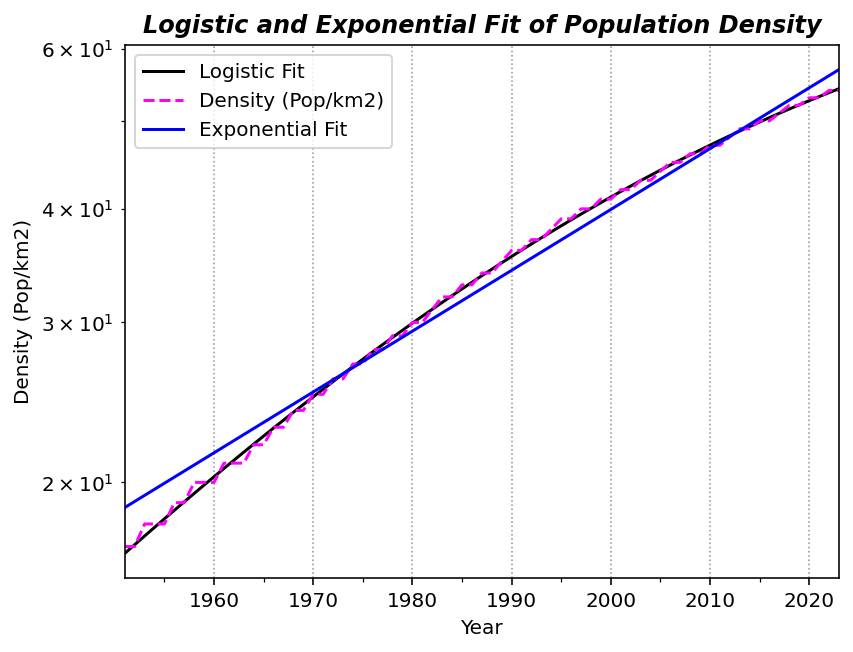

In [157]:
plot_log_expo(data_new)

### Fitting Prediction
Using the Logistic fit calculate prediction for 2030 and create plot of predictions upto 2061 for Population Density

In [25]:
numeric_index = (data_new.index.year - 1951).values
p, cov = curve_fit(logistic, numeric_index, data_new['Density (Pop/km2)'],
                  p0=(60, 0.05, 30))
density_2030 = logistic(2030 - 1951, *p)  # remember to subtract the 1951 as we did when 'training'
print(f" in 2050: {density_2030:g}")

# take 1000 normal random samples for each parameter
sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=1000)

# standard deviation of all possible parameter sampling
density_unc_2030 = np.std(logistic(2030 - 1951, *sample_params.T))  # note the transpose

print(f"Density in 2030: {density_2030:g} +/- {density_unc_2030:g}")


 in 2050: 57.8485
Density in 2030: 57.8485 +/- 0.186545


In [83]:
def plot_logistic_density(data_new, logistic, p, sample_params, time_start=1951, time_end=2061, time_step=5, dpi=144):
    """
    Plot population density data with a logistic fit, including uncertainty.
    """
    fig, ax = plt.subplots(dpi=dpi)
    
    # Create array of prediction times
    time_predictions = np.arange(time_start, time_end, time_step)
    
    # Compute logistic fit predictions
    density_predictions = logistic(time_predictions - time_start, *p)
    
    # Compute uncertainties at each prediction
    density_uncertainties = [np.std(logistic(future_time - time_start, *sample_params.T)) for future_time in time_predictions]

    # Plot data
    ax.plot(data_new.index.year, data_new['Density (Pop/km2)'], 'red', label='Data')
    ax.plot(time_predictions, density_predictions,'--', label='Logistic Fit')
    
    # Fill uncertainty region
    ax.fill_between(time_predictions, 
                    density_predictions - density_uncertainties, 
                    density_predictions + density_uncertainties, 
                    color='grey', alpha=0.3, label="Confidence Interval")
   

    
    # Set labels and legend
    ax.set_xlabel('Year')
    ax.set_ylabel('Density (Pop/km2)')
    ax.legend(shadow=True)
    ax.set_yscale('log')
    
    plt.show()


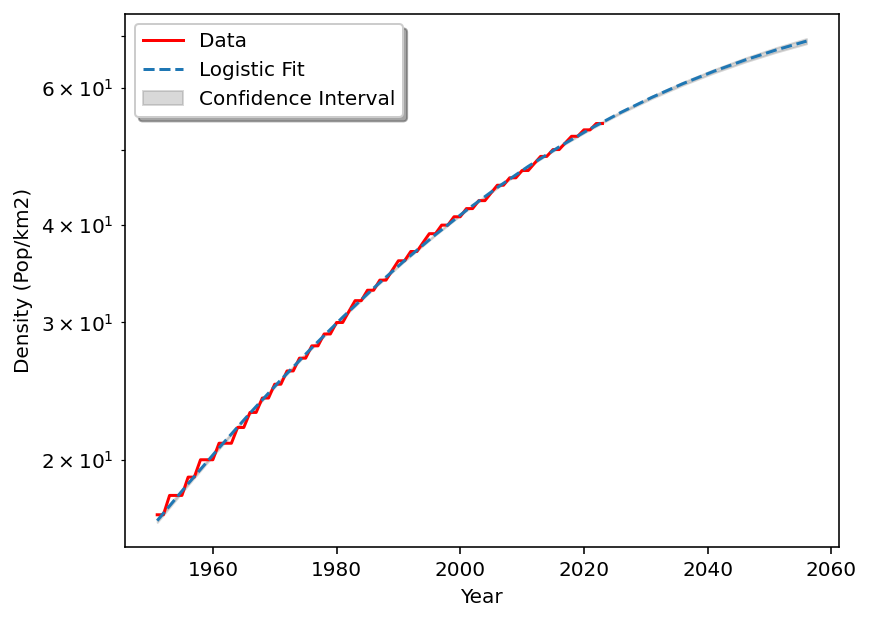

In [84]:
plot_logistic_density(data_new, logistic, p, sample_params)

In [121]:
def plot_logistic_error(data_new, logistic, p, sample_params, time_start=1951, time_end=2061, time_step=5, dpi=144):
    """
    Plot population density data with a logistic fit, including uncertainty and error bars.
    """
    fig, ax = plt.subplots(dpi=dpi)
    
    # Create array of prediction times
    time_predictions = np.arange(time_start, time_end, time_step)
    
    # Compute logistic fit predictions
    density_predictions = logistic(time_predictions - time_start, *p)
    
    # Compute uncertainties at each prediction
    density_uncertainties = [np.std(logistic(future_time - time_start, *sample_params.T)) for future_time in time_predictions]

    # Plot data
    ax.plot(data_new.index.year, data_new['Density (Pop/km2)'], 'red', label='Data')
    
    # Add error bars for the predictions
    ax.errorbar(time_predictions, density_predictions, yerr=density_uncertainties, fmt='.', color='blue', 
                ecolor='black', elinewidth=3, capsize=3, label="Logistic Fit with Errors")
    
    # Fill uncertainty region for predictions
    ax.fill_between(time_predictions, 
                    density_predictions - density_uncertainties, 
                    density_predictions + density_uncertainties, 
                    color='grey', alpha=0.3, label="Confidence Interval")
   
    # Set labels and legend
    ax.set_xlabel('Year')
    ax.set_ylabel('Density (Pop/km2)')
    ax.legend(shadow=True)
    ax.set_yscale('log')
    
    plt.show()


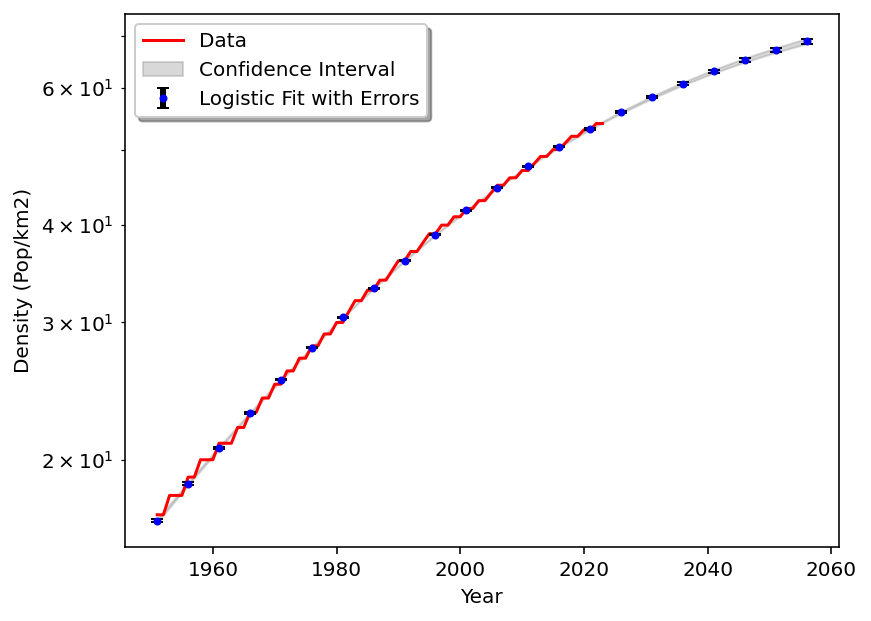

In [122]:
plot_logistic_error(data_new, logistic, p, sample_params)


### Statistical Graph
Plot a heatmap to show statistical relation between 

In [28]:
# dropping the previosly derived columns

x = data_new.drop(columns=['Exponential Fit','Logistic Fit'])

In [29]:
def plot_heatmap(data):
    """
    Plots correlation of all four variables of the dataset
    """
    fig, ax = plt.subplots(dpi=144)
    sns.heatmap(x.corr(), ax=ax, vmin=-1, vmax=1, cmap='RdBu', annot=True)
    plt.title("Correlation coefficient".capitalize(),fontsize=15,fontstyle="italic", fontweight="bold")
    plt.savefig("heatmap", dpi=200)
    return


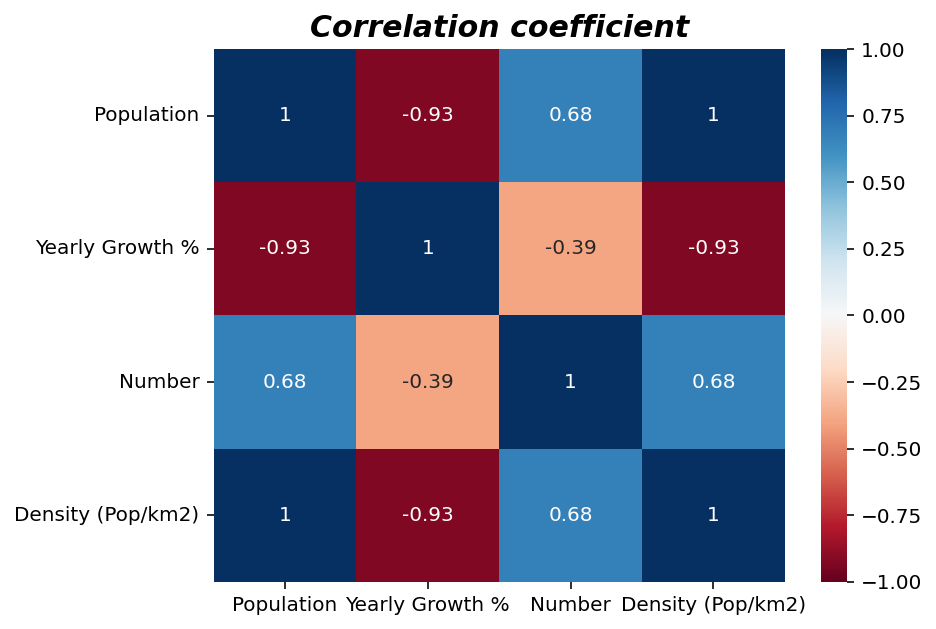

In [30]:
plot_heatmap(x)

In [31]:
#To look at some basic statistics
pd.options.display.float_format = '{:.2f}'.format
x.describe()

,Population,Yearly Growth %,Number,Density (Pop/km2)
count,73.00,73.00,73.00,73.00
mean,5125103969.08,1.61,75972456.03,34.38
std,1689156433.70,0.36,12451809.11,11.37
min,2543130380.00,0.83,43808223.00,17.00
25%,3620655275.00,1.27,70206291.00,24.00
50%,5040984495.00,1.75,80831219.00,34.00
75%,6558176119.00,1.90,84747430.00,44.00
max,8045311447.00,2.24,92471554.00,54.00


From the heatmap we can tell that Yearly growth% and Number columns are not so likely correlated. So we can do the clustering of them

### Clustering 
Perform clustering on Yearly Growth% and Number 

In [32]:
#scaling

from sklearn.preprocessing import RobustScaler
cluster = data_new[['Yearly Growth %', 'Number']].copy()
scaler = RobustScaler()
norm = scaler.fit_transform(cluster)
inv_norm = scaler.inverse_transform(norm)


In [33]:
def one_silhoutte_inertia(n, xy):
    """ 
    Calculates the silhoutte score and WCSS for n clusters 
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters=n, n_init=20)
    # Fit the data
    kmeans.fit(xy)
    labels = kmeans.labels_
    
    # calculate the silhoutte score and inertia
    score = silhouette_score(xy, labels)
    inertia = kmeans.inertia_

    return score, inertia

In [34]:
wcss = []
best_n, best_score = None, -np.inf
for n in range(2, 11):  # 2 to 10 clusters
    score, inertia = one_silhoutte_inertia(n, norm)
    wcss.append(inertia)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:0.2f}")

print(f"Best number of clusters = {best_n:2g}")


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 2 clusters silhoutte score = 0.52


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 3 clusters silhoutte score = 0.52


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 4 clusters silhoutte score = 0.55


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 5 clusters silhoutte score = 0.60


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 6 clusters silhoutte score = 0.57


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 7 clusters silhoutte score = 0.53


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 8 clusters silhoutte score = 0.51


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 9 clusters silhoutte score = 0.51


C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


10 clusters silhoutte score = 0.52
Best number of clusters =  5


### Elbow plot
 Creat Elbow plot to show the best number of cluster

In [35]:
def plot_elbow_method(min_n, max_n, wcss, best_n):
    """
    Plots the elbow method between min_n and max_n
    """
   # plt.axes(facecolor='lightgrey')
    fig, ax = plt.subplots(dpi=144)
    ax.plot(range(min_n, max_n + 1), wcss, 'ks-', markersize=6, markerfacecolor="grey")
    ax.scatter(best_n, wcss[best_n-min_n], marker='X', color='red', facecolors='red',s=150, label="Best Number of cluster" )
    ax.set_xlabel('n')
    ax.set_xlim(min_n, max_n)
    ax.set_ylabel('WCSS')
    ax.set_facecolor('lightgrey')
    plt.legend(frameon=True, shadow=True)
    plt.title("Elbow Method for Clusters Number",fontsize=15,fontstyle="italic", fontweight="bold")
    plt.grid(color='white')
    plt.savefig("Elbow",dpi=150)
    return

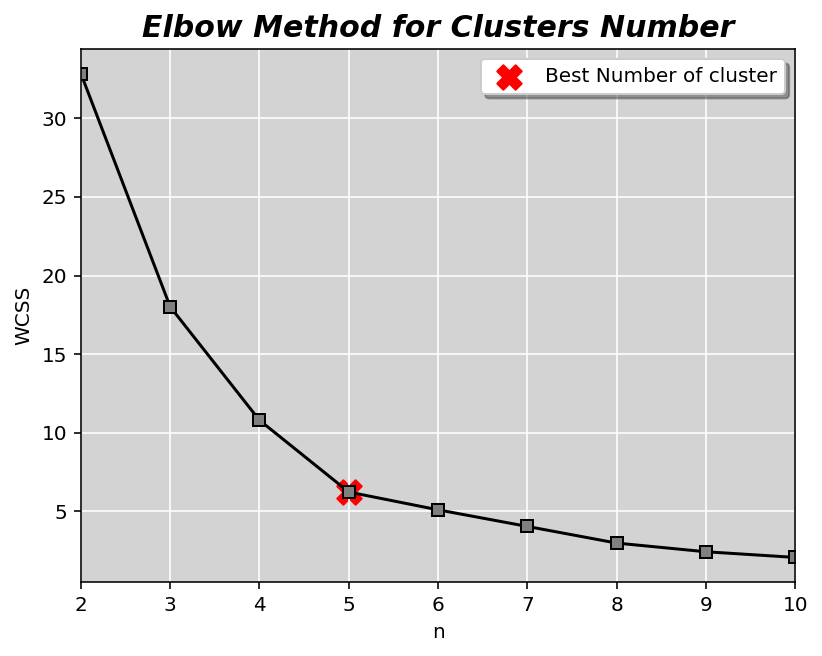

In [36]:
plot_elbow_method(2, 10, wcss, best_n)

In [70]:
def perform_kmeans_clustering(norm, scaler, k):
    """
    Perform KMeans clustering for a range of cluster sizes 
    """
    inv_norm = scaler.inverse_transform(norm)  # Inverse transform to original scale
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(norm)  # Fit KMeans model on the normalized data
    labels = kmeans.labels_

    #Inverse transform the cluster centers to the original scale
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]

        # Predict the cluster labels for the centers
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    
    return labels, xkmeans, ykmeans, cenlabels, inv_norm

In [71]:
def plot_clustered_population_area(labels, xy, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    fig, ax = plt.subplots(figsize=(7,4),dpi=144)
    s = ax.scatter(xy[:, 0], xy[:, 1], c=labels, cmap='coolwarm', marker='o', alpha=0.7)

    ax.scatter(xkmeans, ykmeans,color="black", marker='*', s=100, label='Estimated Centres')

    cbar = fig.colorbar(s, ax=ax)
    cbar.set_ticks(np.unique(labels))
    for cluster in np.unique(labels):
        ax.scatter([], [], color=plt.cm.coolwarm(cluster / max(labels)), label=f'Cluster {cluster+1}')

        ax.legend(title="Clusters", loc='lower left',fontsize=8)
   # ax.legend()
    ax.set_xlabel('Yearly Growth %')
    ax.set_ylabel('Number')
    plt.title(" Visualisation of KMeans Clustering", fontsize=15,fontstyle="italic", fontweight="bold") 
    plt.grid(linestyle="--",color="grey", alpha=0.3)
    plt.savefig("Cluster",dpi=200)
    return

C:\Users\tiasa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


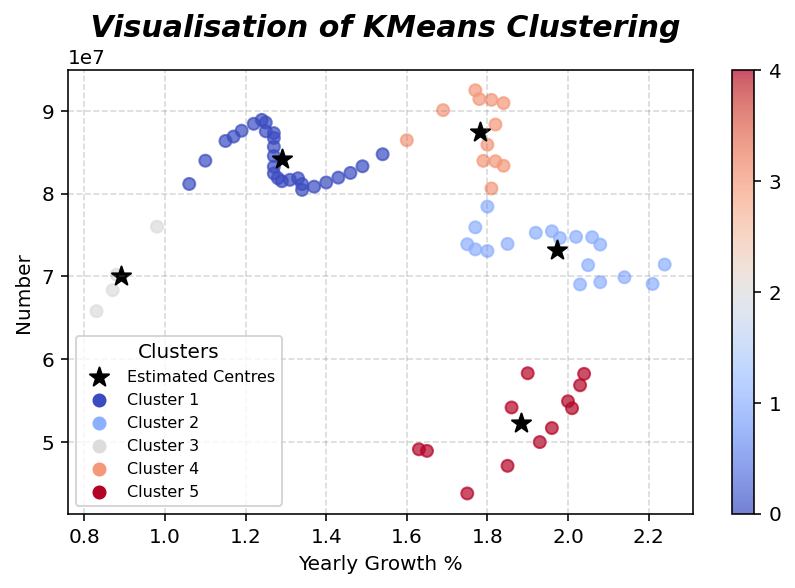

In [72]:
labels, xkmeans, ykmeans, cenlabels, inv_norm = perform_kmeans_clustering(norm, scaler, k=5)
plot_clustered_population_area(labels, inv_norm, xkmeans, ykmeans, cenlabels)